# Photometry example using DS9

This notebook shows an example of some quick photometry investigation using imexam the photutils package.

**In order to run you must install photutils, an astropy affiliated photometry package.**

You can install the latest stable version using: " pip install --no-deps photutils "

In [1]:
#The nbAgg backend allows for nice plotting control inside the notebook
import matplotlib
matplotlib.use('nbagg')

In [2]:
# Import the required modules.

# STDLIB
import os

# THIRD PARTY - ASTROPY
# Make sure you have installed astropy, it's not in Ureka yet.
# After you source your Ureka software, do "easy_install astropy".
from astropy.io import ascii

# THIRD PARTY - OTHER
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import numpy as np
from astropy.io import fits  

import photutils
from photutils import daofind

## Read in Data

In [3]:
# Load the image we are going to use in read-only mode
# you can choose an example image of your own
hdulist = fits.open('iacs01t4q_flt.fits')

In [4]:
# Similar to catfits in iraf
hdulist.info()

Filename: iacs01t4q_flt.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     235   ()              
1    SCI         ImageHDU        81   (1014, 1014)   float32   
2    ERR         ImageHDU        43   (1014, 1014)   float32   
3    DQ          ImageHDU        35   (1014, 1014)   int16   
4    SAMP        ImageHDU        29   (1014, 1014)   int16   
5    TIME        ImageHDU        29   (1014, 1014)   float32   


In [5]:
print(hdulist[0].header['instrume'])
print(hdulist[0].header['detector'])
print(hdulist[0].header['targname'])


WFC3
IR
ANY


## Let's Do Some Science!

We're going to show you two different ways to do this. 
The first example is just a quick way to look at your image

<IPython.core.display.Javascript object>


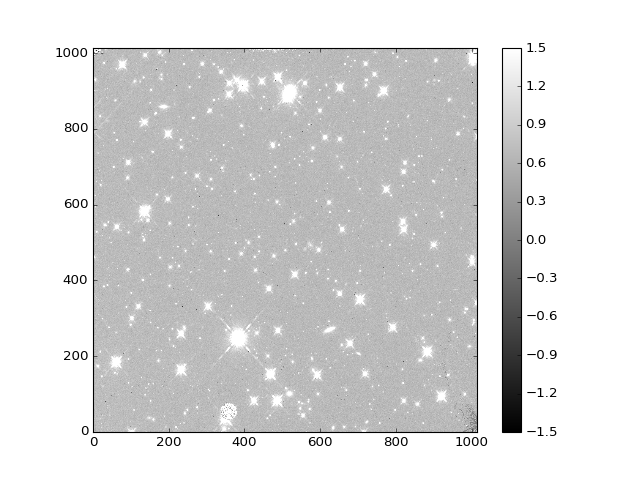

In [6]:
#display a quick image to see what we are working with, you can even use matplotlib here
image = hdulist[1].data
plt.imshow(image, vmin=-1.5, vmax=1.5, cmap=plt.cm.gray, origin='lower')
plt.colorbar() #for reference       

In [7]:
#how about displaying our image in DS9 so we can interact with it a bit more?
#Here I'll import imexam and open a connection to ds9 on my desktop
import imexam
ds9=imexam.connect()
ds9.load_fits('iacs01t4q_flt.fits')
ds9.scale()
ds9.zoomtofit()

<IPython.core.display.Javascript object>


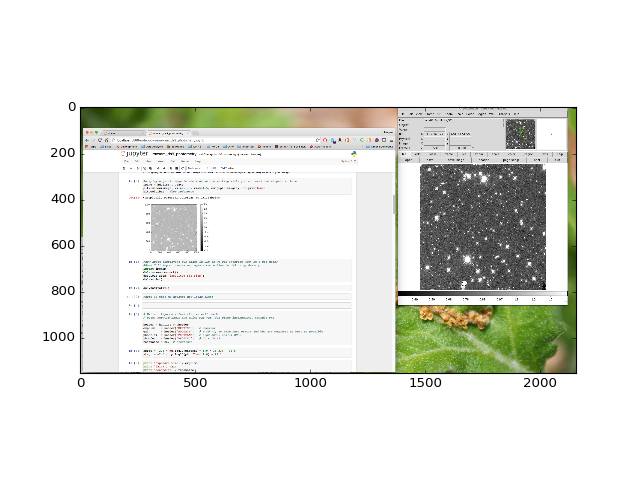

In [8]:
#here is what my desktop now looks like:
desktop=mpimage.imread('desktop1.png')
plt.imshow(desktop,origin='upper')

In [9]:
# Extract keyword values that we will need.
# Note: Keyword names and units may vary for other instruments. Consult DHB.

header = hdulist[0].header
exptime   = header['EXPTIME']   # seconds
photflam  = header["PHOTFLAM"]  # ergs cm^-2 ang^-1 s^-1
photplam  = header["PHOTPLAM"]  # erg cm^-2 s^-1 Hz^-1


In [10]:
stzpt = -2.5 * np.log10(photflam* 1.0) - 21.1
abmag = -2.5 * np.log10(photflam*1.0) - 21.1 -  5 * np.log10(photplam) + 18.692

In [11]:
print('Exposure time: {0}'.format(exptime))
print('STMAG zeropoint: {0}'.format(stzpt))
print('ABMAG zeropoint: {0}'.format(abmag))

Exposure time: 227.93692
STMAG zeropoint: 28.187480123828642
ABMAG zeropoint: 25.946227204106755


## Finding Sources - using photutils

In [12]:
image = hdulist[1].data  # Input will be EXT 1, same as above

In [13]:
#now we subtract a median background from the image, consider what you are doing here,'
#taking the straight median might not be the best way in such a crowded field. We will
#Use the background subtracted image for the rest of the example
skybkg=np.median(image)
print(skybkg)
image -= skybkg

0.709041


In [14]:
#let's also get the background deviation
from astropy.stats import median_absolute_deviation as mad
bkg_sigma = 1.4826 * mad(image)
print(bkg_sigma)

0.104878924298


In [15]:
#now we'll use the daofind method in photutils to find out sources
sources = daofind(image, fwhm=2.5, threshold=3.*bkg_sigma)

In [16]:
# See just a few lines of output, with no print it uses a pretty print in the notebook
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,100.955928507,0.0770339141893,0.965562616627,-0.782752697481,-0.837242139485,25.0,0.0,50.5657653809,122.091117796,-5.21671017476
2,509.222235773,-0.266029658021,0.892794717353,-0.313890342482,-0.622701779633,25.0,0.0,0.380710721016,1.19338298998,-0.191949608216
3,988.424702503,1.12650441264,0.298777691379,0.491006920069,-0.0559293165187,25.0,0.0,-0.0267254114151,1.9205564786,-0.708567707915
4,107.80356052,1.30362460375,0.271995607133,-0.0432056133434,-0.361947450555,25.0,0.0,0.501069664955,1.13022104654,-0.132908475757
5,212.959499671,0.280634528505,0.529991656847,0.100174692444,0.295869343229,25.0,0.0,0.412734985352,1.57564665752,-0.493647081272
6,577.33706541,2.19922450221,0.764338107864,0.328956978175,0.0492835984833,25.0,0.0,0.304625749588,1.05185937811,-0.0548942084
7,984.207313379,1.44690275047,0.484358483919,0.928291960743,-0.65896732081,25.0,0.0,0.0910112261772,1.43925083844,-0.39534122782
8,992.333369118,1.73898687508,0.440117972582,0.0595674167985,-0.256757303845,25.0,0.0,0.0356502532959,1.90241589438,-0.698263664374
9,852.253523869,3.11359503672,0.673605131515,0.0428463038208,-0.303273277199,25.0,0.0,0.222710430622,1.09266427196,-0.0962168567643


## Visualizing the Sources
<p align="left">... and taking advantage of astropy tables </p>

In [17]:
# what does dsofind return?
print(type(sources))

<class 'astropy.table.table.Table'>


In [18]:
# extract xcenter values
xcen=sources['xcentroid']
print(xcen)

  xcentroid  
-------------
100.955928507
509.222235773
988.424702503
 107.80356052
212.959499671
 577.33706541
984.207313379
992.333369118
852.253523869
975.930972153
          ...
  378.8698316
401.263334185
 405.34132522
425.626780601
444.296901091
468.455781633
 519.34268357
544.669582395
554.484416327
586.576266695
 999.65336661
Length = 1605 rows


<IPython.core.display.Javascript object>


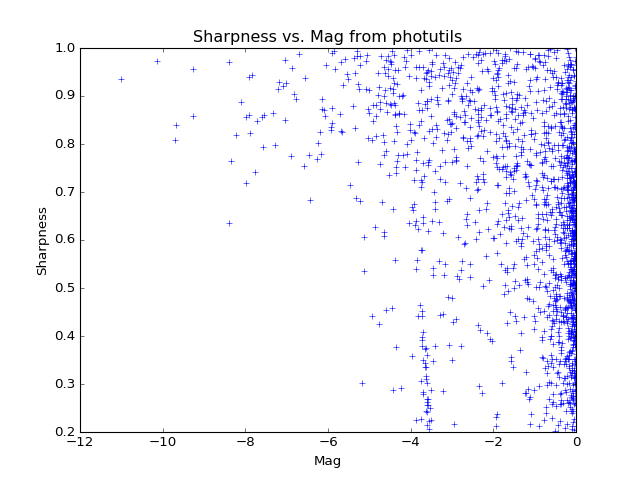

In [19]:
# Plot of the sharpness versus the mag as blue pluses
plt.plot(sources['mag'], sources['sharpness'], 'b+')
plt.title('Sharpness vs. Mag from photutils')
plt.xlabel('Mag')
plt.ylabel('Sharpness')

# Save the plot as a PDF.
# Matplotlib automatically determines format from given extension.
#plt.savefig('sharp_v_mag_photutil.pdf')

In [20]:
# Select stars with sharpness greater than 0.9
# use boolean arrays

#Want to save a table of just the sharper sources? You can do this:
sharp_sources = sources[sources['sharpness'] >0.9]
sharp_sources

print('Number of sharp stars: {0}'.format(len(sharp_sources)))

Number of sharp stars: 273


<IPython.core.display.Javascript object>


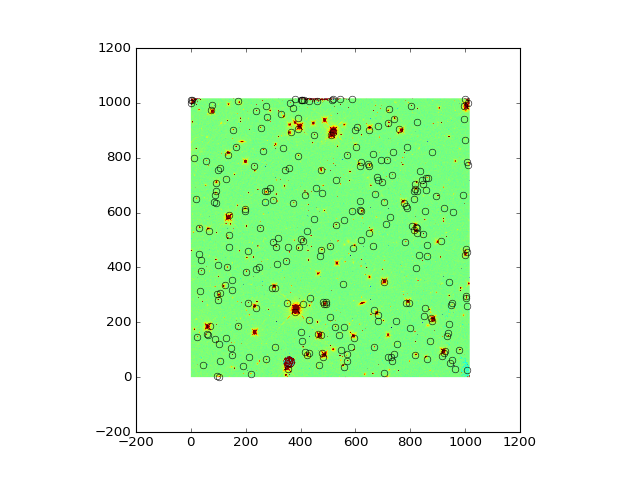

In [21]:
# Plot the image again in a different color using matplotlib, just as an example
plt.imshow(image, vmin=-3., vmax=3., cmap=plt.cm.jet)

# Only show the high sharpness stars as black circles.
plt.plot(sharp_sources['xcentroid'], sharp_sources['ycentroid'], 'ko', mfc='None')

In [21]:
#now lets do the same thing in DS9
stars = zip(sharp_sources['xcentroid'],sharp_sources['ycentroid'],sharp_sources['id'])
ds9.mark_region_from_array(stars)

circle 100.955928507 0.0770339141893 4
text 110.95592850671602 10.077033914189258 '1' #font=times
circle 96.1624400744 3.96456165607 4
text 106.16244007443544 13.96456165606525 '13' #font=times
circle 218.101965625 12.3167169558 4
text 228.10196562455593 22.316716955798874 '35' #font=times
circle 704.683398316 13.4965806754 4
text 714.6833983156313 23.49658067544742 '43' #font=times
circle 1007.87549281 27.273031682 4
text 1017.8754928121118 37.273031681956965 '73' #font=times
circle 354.594947909 29.7206441976 4
text 364.59494790898543 39.720644197630946 '75' #font=times
circle 963.319676213 30.6033517538 4
text 973.3196762131537 40.60335175383391 '77' #font=times
circle 558.99264964 36.6065419558 4
text 568.9926496402701 46.60654195582069 '91' #font=times
circle 188.558862195 41.6897261371 4
text 198.55886219508787 51.68972613711985 '102' #font=times
circle 466.01492321 43.2922622677 4
text 476.0149232101938 53.29226226769389 '108' #font=times
circle 43.5895557745 44.0001585666 4
tex

Image saved to /Users/sosey/test_images/iacs01t4q_flt.fits_snap.png


<IPython.core.display.Javascript object>


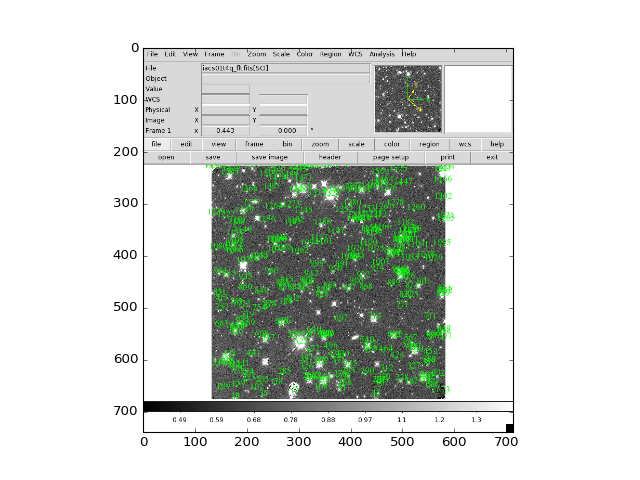

In [22]:
#here's what the DS9 window looks like now
ds9.grab()

## Aperture Photometry

In [23]:
#photutils takes an aperture specfication along with the image as input:
#You can do a local background subtraction by specifying the apertures for the background in a similar manner
from photutils import aperture_photometry, CircularAperture
positions = (sharp_sources['xcentroid'], sharp_sources['ycentroid'])    
apertures = CircularAperture(positions, r=4.)    
phot_table = aperture_photometry(image, apertures)    
phot_table

aperture_sum,xcenter,ycenter
,pix,pix
float64,float64,float64
195.671368292,100.955928507,0.0770339141893
47.9751033099,96.1624400744,3.96456165607
66.0559424506,218.101965625,12.3167169558
1.12102921885,704.683398316,13.4965806754
-22.8188221217,1007.87549281,27.273031682
237.944124351,354.594947909,29.7206441976
9.56530537681,963.319676213,30.6033517538
9.60667928685,558.99264964,36.6065419558


## Analyze Photometry Results

Let's make a histogram of the recovered instrumental magnitudes

In [24]:
mags=phot_table['aperture_sum']

In [25]:
#wfc3 data is already in countrate, but no aperture correction has been applied here yet
goodmags=-2.5 *np.log10(mags[mags>0.] * photflam) - 21.1 

<IPython.core.display.Javascript object>


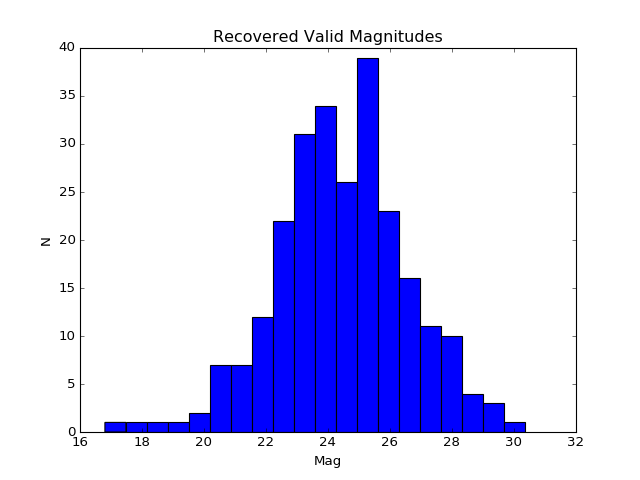

In [26]:
#Nifty, right? Now lets plot a histogram of our values
plt.hist(goodmags, bins=20)
plt.xlabel('Mag')
plt.ylabel('N')
plt.title('Recovered Valid Magnitudes')

Note: The mags above are different from the mags in the iraf example mostly because a different zeropoint was used (as input to the phot task in the pars parameter set)

## Closing Time

In [27]:
# It is a good practice to close any open file pointers.
# You might also want to check out the notes on  using the "with open as" clause
hdulist.close()

In [28]:
ds9.close() #close the ds9 window